In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import qutip
import theano
import theano.tensor as T
from collections import OrderedDict
import itertools
from QubitNetwork import QubitNetwork
from qubit_network import load_network_from_file, sgd_optimization, transfer_J_values
import utils
from utils import chop, complex2bigreal, bigreal2complex
from results_analysis_utils import *

pairs = list(itertools.combinations(range(4), 2))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Test with interactions from *Banchi et al.*.
The Fredkin gate is indeed reproduced with good fidelity, and regardless of the initial ancilla state.

In [16]:
net_paper = QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=('all', ['zz', 'xx', 'yy', 'z', 'x']),
    ancillae_state=qutip.basis(2, 0),
    target_gate=qutip.fredkin()
)
net_paper.J.set_value(np.zeros_like(net_paper.J.get_value()))

Jvalues = net_paper.J.get_value()

J01xx = 13.6
J02xx = J01xx

J12xx = -4.712
J12yy = J12zz = J12xx

J13xx = 8.4
J23xx = J13xx

J01zz = 11.15
J02zz = J01zz

h3x = 1.025
h0z = np.pi

Jvalues[net_paper.tuple_to_J_index(((0, 1), 'xx'))] = J01xx / 4
Jvalues[net_paper.tuple_to_J_index(((0, 2), 'xx'))] = J02xx / 4
Jvalues[net_paper.tuple_to_J_index(((1, 2), 'xx'))] = J12xx / 4
Jvalues[net_paper.tuple_to_J_index(((1, 2), 'yy'))] = J12yy / 4
Jvalues[net_paper.tuple_to_J_index(((1, 2), 'zz'))] = J12zz / 4
Jvalues[net_paper.tuple_to_J_index(((1, 3), 'xx'))] = J13xx / 4
Jvalues[net_paper.tuple_to_J_index(((2, 3), 'xx'))] = J23xx / 4
Jvalues[net_paper.tuple_to_J_index(((0, 1), 'zz'))] = J01zz / 4
Jvalues[net_paper.tuple_to_J_index(((0, 2), 'zz'))] = J02zz / 4
Jvalues[net_paper.tuple_to_J_index((0, 'z'))] = h0z / 2
Jvalues[net_paper.tuple_to_J_index((3, 'x'))] = h3x / 2

net_paper.J.set_value(Jvalues)

# net_paper.test_fidelity(n_samples=1000)
gate = qutip.Qobj(net_paper.get_current_gate(), dims=[[2, 2, 2, 2]] * 2)
gate = chop(gate).ptrace([0, 1, 2])
gate = gate * np.exp(-1j * np.angle(gate[0, 0]))
gate = gate / gate[0, 0]
chop(gate, 0.01)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 1.          0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.99999938  0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.99999938  0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.99999776  0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.99999641  0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.99999911  0.        ]
 [ 0.          0.          0.          0.          0.          0.99999911
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.99999962]]

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


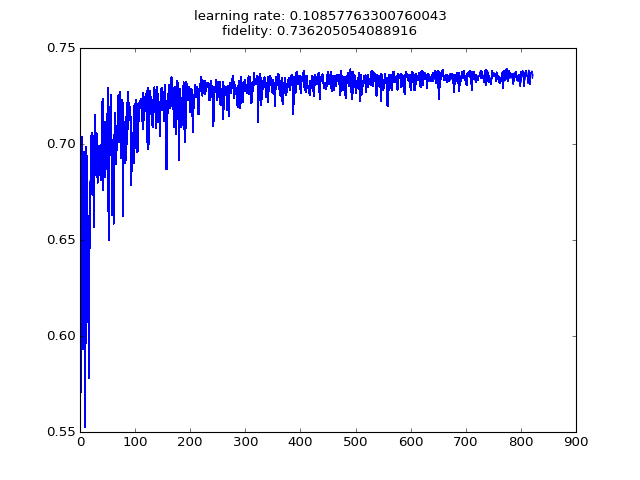

Finished training
Final fidelity: 0.7432488902213642


In [19]:
# set up a set of interaction mimicking those of Banchi et al.
interactions = []
for pair in pairs:
    interactions.append((pair, 'xx'))
    interactions.append((pair, 'yy'))
    interactions.append((pair, 'zz'))

interactions.append((0, 'z'))
interactions.append((3, 'x'))

# define the network
net = QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=interactions,
    ancillae_state=qutip.basis(2, 0)
)
net.J.set_value(np.ones_like(net.J.get_value()))

# train the network
sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=2,
    target_gate=qutip.fredkin(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

In [26]:
# [item for item in group_similar_interactions(net) if len(item) > 1]
net.J.get_value()

array([ 0.51838337,  0.46427126,  0.6856528 ,  0.49134493,  0.46988736,
        0.69652614,  1.37984755,  1.40684852, -0.09900174,  0.48163679,
        0.45744568,  1.07382171,  0.4586584 ,  0.51771868,  0.73676567,
        0.46433962,  0.51649699,  0.70010093,  0.17629014, -0.02053136])

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


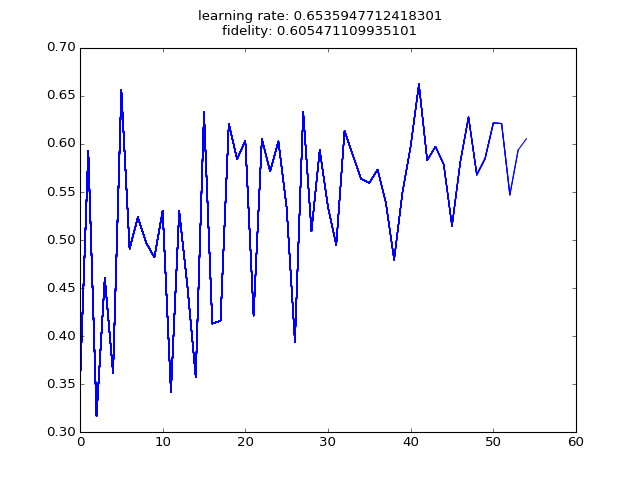

In [ ]:
# set up a set of interaction mimicking those of Banchi et al.
net_topology = OrderedDict()
net_topology[((0, 1), 'xx')] = '1'
net_topology[((0, 2), 'xx')] = '1'
net_topology[((1, 2), 'xx')] = '2'
net_topology[((1, 2), 'yy')] = '2'
net_topology[((1, 2), 'zz')] = '2'
net_topology[((1, 3), 'xx')] = '3'
net_topology[((2, 3), 'xx')] = '3'
net_topology[((0, 1), 'zz')] = '4'
net_topology[((0, 2), 'zz')] = '4'
net_topology[(3, 'x')] = '5'
net_topology[(0, 'z')] = '6'

# define the network
net = QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    ancillae_state=qutip.basis(2, 0),
    net_topology=net_topology,
    target_gate=qutip.fredkin()
)
# net.J.set_value(np.ones_like(net.J.get_value()))

# net.build_H_factors(symbolic_result=False).shape
# net.test_fidelity()
# train the network
sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=2,
    target_gate=qutip.fredkin(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

### A Fredkin gate is be obtained with very good fidelity, $\simeq 99.999\%$, starting with all interactions on, and only $\sigma_z$ operators as self-interactions.

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


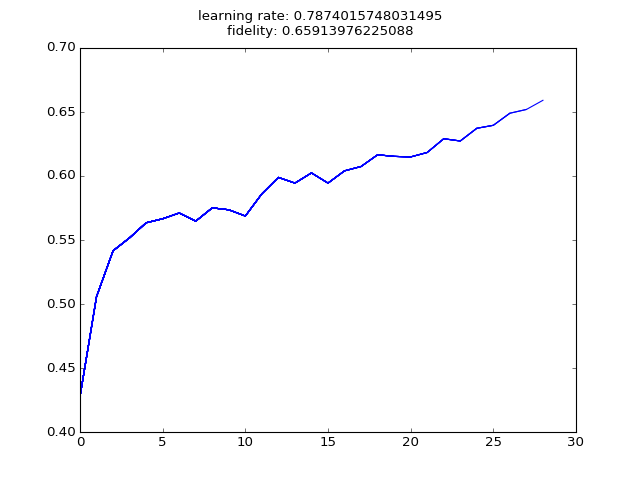

Finished training


In [96]:
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    interactions='all',
    self_interactions=('all', ['z']),
    system_qubits=[0, 1, 2]
#     J=new_Jvalues
)
net, funcs = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=200,
    batch_size=10,
    target_gate=qutip.fredkin(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
#     saveafter_file='nets/fredkin_best.pickle'
)

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


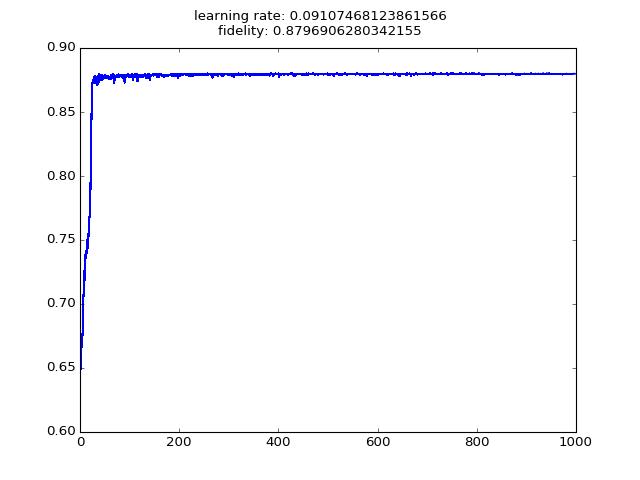

Finished training


In [180]:
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=('all', ['yy', 'zz']),
    self_interactions=('all', ['z'])
)
net = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=10,
    target_gate=qutip.fredkin(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


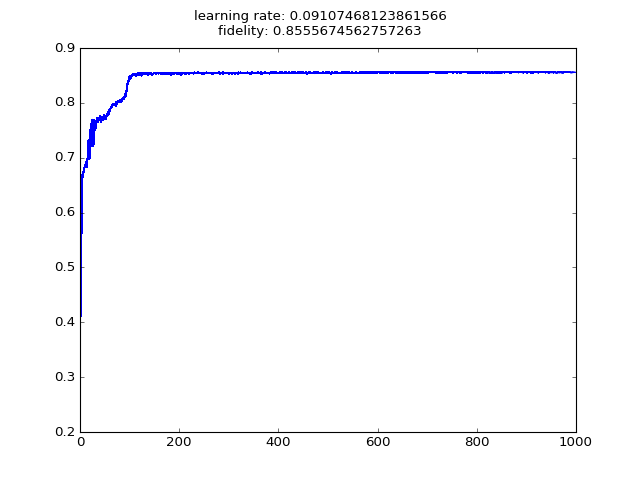

Finished training


In [182]:
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=('all', ['xx', 'yy', 'zz']),
    self_interactions=('all', ['x', 'y', 'z'])
)
net = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=10,
    target_gate=qutip.fredkin(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


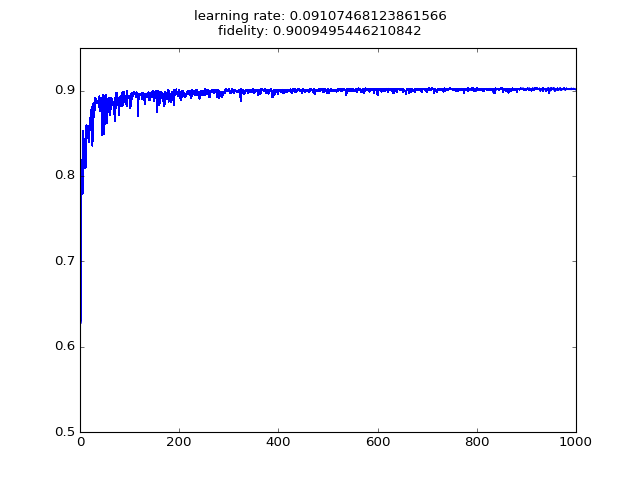

Finished training


In [184]:
net = QubitNetwork.QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions=('all', ['xx', 'yy', 'zz', 'xy']),
    self_interactions=('all', ['x', 'y', 'z'])
)
net = QubitNetwork.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=1000,
    batch_size=2,
    target_gate=qutip.fredkin(),
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
)

In [98]:
net = QubitNetwork.load_network_from_file('nets/fredkin_best.pickle')
gate = qutip.Qobj(net.get_current_gate(), dims=[[2, 2, 2, 2]] * 2)

fred = gate.ptrace([0, 1, 2]).data.toarray()
fred[np.abs(fred) < 1e-3] = 0.0
fred = fred * np.exp(-1j * np.angle(fred[0, 0]))
fred.imag[abs(fred.imag) <  1e-3] = 0.0

qutip.Qobj(fred)

Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[ 1.99999127  0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          1.00001791  0.99999623  0.          0.          0.          0.
   0.        ]
 [ 0.          0.99999402  0.99996561  0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          1.99999111  0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          1.99999109  0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.99999012
   0.9999961   0.        ]
 [ 0.          0.          0.          0.          0.          0.99999413
   0.99999293  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.99999134]]

In [127]:
net = QubitNetwork.load_network_from_file('nets/fredkin_best.pickle')
gate = qutip.Qobj(net.get_current_gate(), dims=[[2, 2, 2, 2]] * 2)

p00 = qutip.ket2dm(qutip.basis(2, 0))
p11 = qutip.ket2dm(qutip.basis(2, 1))
p01 = qutip.Qobj([[0, 1], [0, 0]])
p10 = qutip.Qobj([[0, 0], [1, 0]])

i3 = qutip.tensor([qutip.qeye(2) for _ in range(3)])
ntlp = utils.normalize_topleft_phase

extracted1 = (qutip.tensor(i3, p00) * gate * qutip.tensor(i3, p00)).ptrace([0, 1, 2])
extracted2 = (qutip.tensor(i3, p11) * gate * qutip.tensor(i3, p11)).ptrace([0, 1, 2])
extracted3 = (qutip.tensor(i3, p01) * gate * qutip.tensor(i3, p01)).ptrace([0, 1, 2])
extracted4 = (qutip.tensor(i3, p10) * gate * qutip.tensor(i3, p10)).ptrace([0, 1, 2])

display(chop(ntlp(chop(extracted1))))
display(ntlp(chop(extracted2)))
display(ntlp(chop(extracted3)))
display(ntlp(chop(extracted4)))

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[ 0.38262553  0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.38271334  0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.38271012  0.          0.          0.          0.
   0.        ]
 [ 0.00113171  0.          0.          0.38268825  0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.38260567  0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.38270471  0.        ]
 [ 0.          0.          0.          0.          0.          0.38273547
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.38260234]]

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[ 0.38230036+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.j          0.38269167+0.j
   0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j        ]
 [ 0.00000000+0.j          0.38272269+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.38240083+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j          0.38262003+0.j          0.00000000+0.j
   0.00000000+0.j          0.0000

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

In [134]:
Jvalues = net.J.get_value()
display(Jvalues)
# [net.J_index_to_interaction(v) for v in np.where(np.abs(Jvalues) < 1e-3)[0]]
# net.active_hs
Jvalues[[net.tuple_to_xs_index(((0, 2), 'xy')), net.tuple_to_xs_index(((1, 2), 'xy'))]]

array([ -3.33662302e-04,   6.29587306e-06,  -1.57899208e-05,
         9.57945427e-05,   3.48637240e-01,   9.58270644e-01,
        -3.31680735e+00,   4.96027968e-02,   2.44559586e-01,
        -6.90826794e-01,   3.23379086e-01,   6.55609475e-01,
        -1.81265239e+00,   3.47624011e-01,   9.56951893e-01,
        -3.31586128e+00,   4.93771621e-02,   2.43686913e-01,
        -6.88574952e-01,  -2.78305496e-02,  -2.43816683e-01,
         1.07247231e+00,  -9.68272064e-01,  -1.22447583e+00,
        -8.84021718e-04,   1.24402550e+00,  -9.69491489e-01,
         1.16198049e-03,   1.27472394e-03,   5.27919157e-03,
         2.35810340e+00,   7.67137183e-01,  -4.07293974e-02,
         1.72312350e-01,  -4.08734884e-02,   6.57406318e-01,
         4.79221787e-01,   1.73037299e-01,   4.79996568e-01,
        -1.03380509e+00,  -9.43497636e-02,  -9.22462741e-02,
         1.55768464e-01,  -1.02434314e-01,  -2.73949437e-01,
         4.65624355e-01,   4.73042385e-01,   9.47372533e-01,
        -1.61224118e+00,

array([ 0.32337909,  0.00127472])

In [177]:
groups = utils.group_similar_elements(Jvalues)
groups = [g for g in groups if len(g) > 1]

[[net.J_index_to_interaction(i) for i in groups[j]] for j in range(len(groups))]

[[(0, 'z'), (1, 'z'), (2, 'z'), (3, 'z'), ((0, 3), 'xz')],
 [((0, 1), 'xz'), ((0, 2), 'xz')],
 [((0, 1), 'yx'), ((0, 2), 'yx')],
 [((0, 1), 'yy'), ((0, 2), 'yy')],
 [((0, 3), 'yz'), ((0, 3), 'zx')],
 [((1, 2), 'xy'), ((1, 2), 'yx')],
 [((1, 2), 'xz'), ((1, 2), 'zx')],
 [((1, 2), 'yz'), ((1, 2), 'zy')],
 [((1, 3), 'xx'), ((2, 3), 'xx')],
 [((1, 3), 'xy'), ((2, 3), 'xy')],
 [((1, 3), 'yx'), ((2, 3), 'yx')]]